In [1]:
# import torch
import torch

# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# set random seed variable
SEED = 42

### Make a binary classification dataset using scikit learns `make_moons()` function

         x1        x2  labels
0  0.008727  0.368174       1
1  0.921384 -0.496905       1
2  0.940226 -0.498212       1
3  0.465875 -0.345406       1
4 -0.850412  0.526117       0


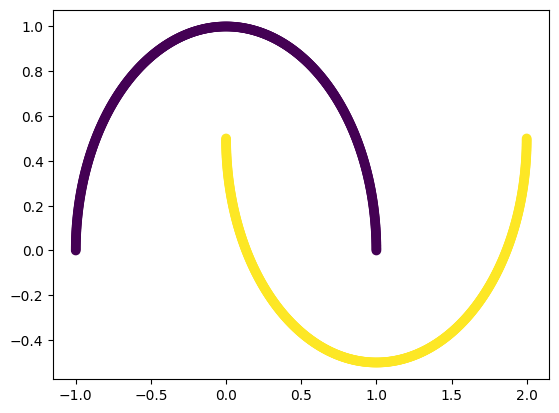

In [2]:
# use sklearn to import the make_moons dataset
from sklearn.datasets import make_moons
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting

data, labels = make_moons(n_samples = 1000, random_state = SEED)

# turn data and labels into pandas dataframes
data = pd.DataFrame(data, columns = ["x1", "x2"])
data["labels"] = labels
print(data.head())

# plot the data
plt.scatter(data.x1, data.x2, c = labels)

### Graph appears to be 2 half moons

In [3]:
# we'll now turn the dataframe into tensor floats
data = torch.from_numpy(data.values).type(torch.float)

# split data using sci-kit learn
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size = 0.2, random_state = SEED)

# put the data into device
X_train, X_test, y_train, y_test = map(lambda x: x.to(device), [X_train, X_test, y_train, y_test])

# view the shapes of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


In [4]:
import torch.nn as nn # for neural networks
import torch.nn.functional as F # for activation functions

# create a class for the model
class BinaryModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.big_layer = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, output_size),
        )

    def forward(self, x):
        x = self.big_layer(x)
        return x
    
# create an instance of the model
model = BinaryModel(2, 1).to(device)


In [5]:
# make loss function
loss_fn = nn.BCEWithLogitsLoss()

# make optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

### We'll use torchmetrics for the accuaracy

In [6]:
!pip install torchmetrics -q

In [7]:
import torchmetrics # for metrics

# create the training loop
epochs = 1000

# create accuracy metric
acc = torchmetrics.classification.BinaryAccuracy().to(device)

# create training loop
for epoch in range(epochs):
    acc.reset()
    model.train()

    # forward pass
    y_preds = model(X_train)

    # calculate the loss
    loss = loss_fn(y_preds, y_train.unsqueeze(dim =1))

    # calculate the accuracy
    predictions = torch.sigmoid(y_preds).round().squeeze()
    accuracy = acc(predictions, y_train)

    # zero grad
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # step
    optimizer.step()

    # test
    model.eval()
    with torch.inference_mode():
        acc.reset()
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test.unsqueeze(dim = 1))
        test_predicitons = torch.sigmoid(test_preds).round().squeeze()
        test_acc = acc(test_predicitons, y_test)

    # print results
    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Train Acc: {accuracy*100:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc*100:.5f}")




Epoch: 1 | Train Loss: 0.70205 | Train Acc: 50.00000 | Test Loss: 0.69176 | Test Acc: 50.00000
Epoch: 101 | Train Loss: 0.23794 | Train Acc: 88.75000 | Test Loss: 0.24238 | Test Acc: 89.50000
Epoch: 201 | Train Loss: 0.18487 | Train Acc: 91.75000 | Test Loss: 0.18618 | Test Acc: 92.50000
Epoch: 301 | Train Loss: 0.14089 | Train Acc: 94.00000 | Test Loss: 0.14245 | Test Acc: 94.00000
Epoch: 401 | Train Loss: 0.09299 | Train Acc: 96.37500 | Test Loss: 0.09405 | Test Acc: 97.50000
Epoch: 501 | Train Loss: 0.05432 | Train Acc: 99.25000 | Test Loss: 0.05462 | Test Acc: 99.50000
Epoch: 601 | Train Loss: 0.03204 | Train Acc: 100.00000 | Test Loss: 0.03213 | Test Acc: 100.00000
Epoch: 701 | Train Loss: 0.02060 | Train Acc: 100.00000 | Test Loss: 0.02066 | Test Acc: 100.00000
Epoch: 801 | Train Loss: 0.01440 | Train Acc: 100.00000 | Test Loss: 0.01444 | Test Acc: 100.00000
Epoch: 901 | Train Loss: 0.01073 | Train Acc: 100.00000 | Test Loss: 0.01076 | Test Acc: 100.00000
Epoch: 1000 | Train Loss

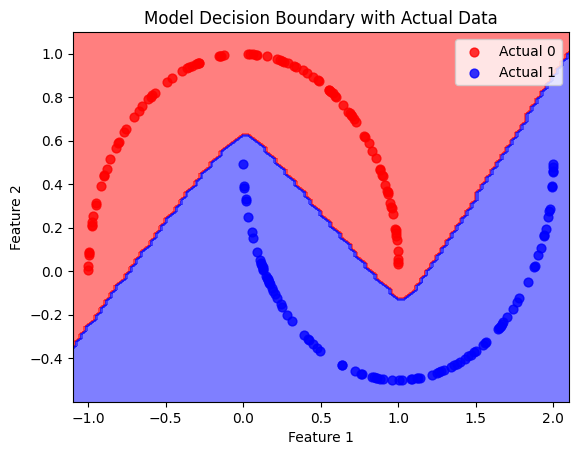

In [8]:
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y):
    model.eval()  # Set the model to evaluation mode

    # put model and data on cpu
    model.cpu()
    X = X.cpu()
    y = y.cpu()

    # Define the axis boundaries of the plot
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Create a meshgrid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict using the model
    with torch.inference_mode(): 
        grid_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).cpu()
        preds = model(grid_tensor)
        preds = torch.round(torch.sigmoid(preds)).reshape(xx.shape).numpy()

    # Create a color map
    cmap = ListedColormap(["#FF0000", "#0000FF"])

    # Plot the contour map
    plt.contourf(xx, yy, preds, cmap=cmap, alpha=0.5)

    # Plot the actual data, separating classes for the legend
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', s=40, label="Actual 0", alpha=0.8)
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', s=40, label="Actual 1", alpha=0.8)

    # Add labels and legend
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Model Decision Boundary with Actual Data")
    plt.legend()

    # Show the plot
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model, X_test, y_test)


In [9]:
# define tanh function
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

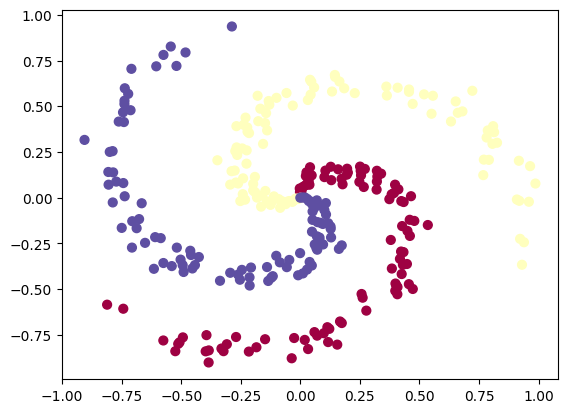

In [10]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [17]:
# define spiral model (same as binary model but with 3 output classes)
class SpiralModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.big_layer = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, output_size),
        )
    
    def forward(self, x):
        return self.big_layer(x)
    
# create an instance of the model
model = SpiralModel(2, 3).to(device)

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# turn data into tensors and put on device
X_train, X_test, y_train, y_test = map(lambda x: torch.from_numpy(x).type(torch.float).to(device), [X_train, X_test, y_train, y_test])

# see shapes of data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([240, 2]) torch.Size([240]) torch.Size([60, 2]) torch.Size([60])


In [19]:
# make loss function
loss_fn = nn.CrossEntropyLoss()

# make optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [25]:
# create training loop
epochs = 100

# create accuracy metric
acc = torchmetrics.classification.Accuracy(task = "multiclass", num_classes = 3).to(device)

# create training loop
for epoch in range(epochs):
    acc.reset()
    model.train()

    # forward pass
    y_preds = model(X_train)

    # calculate the loss
    loss = loss_fn(y_preds, y_train.long())

    # calculate the accuracy
    predictions = torch.argmax(y_preds, dim = 1)

    # zero grad
    optimizer.zero_grad()

    # backprop
    loss.backward()

    # step(gradient descent)
    optimizer.step()

    # test
    model.eval()
    with torch.inference_mode():
        acc.reset()
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test.long())
        test_predictions = torch.argmax(test_preds, dim = 1)
        test_acc = acc(test_predictions, y_test.long())

    # print results
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Train Acc: {accuracy*100:.5f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc*100:.5f}")

Epoch: 1 | Train Loss: 0.02229 | Train Acc: 100.00000 | Test Loss: 0.78508 | Test Acc: 98.33334
Epoch: 11 | Train Loss: 0.01880 | Train Acc: 100.00000 | Test Loss: 0.75688 | Test Acc: 98.33334
Epoch: 21 | Train Loss: 0.01843 | Train Acc: 100.00000 | Test Loss: 0.78910 | Test Acc: 98.33334
Epoch: 31 | Train Loss: 0.02073 | Train Acc: 100.00000 | Test Loss: 0.85176 | Test Acc: 98.33334
Epoch: 41 | Train Loss: 0.01824 | Train Acc: 100.00000 | Test Loss: 0.83831 | Test Acc: 98.33334
Epoch: 51 | Train Loss: 0.01841 | Train Acc: 100.00000 | Test Loss: 0.87458 | Test Acc: 98.33334
Epoch: 61 | Train Loss: 0.01848 | Train Acc: 100.00000 | Test Loss: 0.87298 | Test Acc: 98.33334
Epoch: 71 | Train Loss: 0.05290 | Train Acc: 100.00000 | Test Loss: 0.72656 | Test Acc: 98.33334
Epoch: 81 | Train Loss: 4.20581 | Train Acc: 100.00000 | Test Loss: 2.30159 | Test Acc: 80.00000
Epoch: 91 | Train Loss: 0.12624 | Train Acc: 100.00000 | Test Loss: 0.18749 | Test Acc: 96.66666
Epoch: 100 | Train Loss: 0.1333

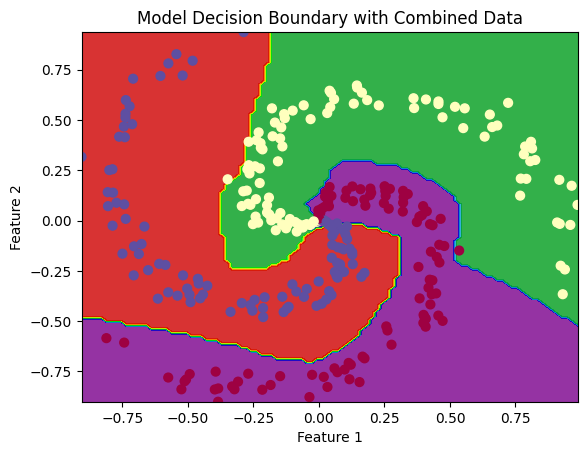

In [51]:
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_decision_boundary_combined(model, X_train, y_train, X_test, y_test):
    model.eval()  # Set the model to evaluation mode

    # Combine training and test datasets
    X_combined = torch.cat([X_train, X_test], dim=0)
    y_combined = torch.cat([y_train, y_test], dim=0)

    # Move model and data to CPU
    model.cpu()
    X_combined = X_combined.cpu()
    y_combined = y_combined.cpu()

    # Define the axis boundaries of the plot
    x_min, x_max = X_combined[:, 0].min(), X_combined[:, 0].max()
    y_min, y_max = X_combined[:, 1].min(), X_combined[:, 1].max()

    # Create a meshgrid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict using the model
    with torch.inference_mode():
        grid_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]).cpu()
        preds = model(grid_tensor)
        preds = torch.argmax(preds, dim=1).reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, preds, cmap="nipy_spectral", alpha=0.8)

    # Plot the combined actual data points using the same color map as the original plot
    plt.scatter(X_combined[:, 0], X_combined[:, 1], c=y_combined, s=40, cmap=plt.cm.Spectral)

    # Add labels and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Model Decision Boundary with Combined Data")

    # Show the plot
    plt.show()

# Example usage (replace 'model', 'X_train', 'y_train', 'X_test', 'y_test' with your actual variables)
plot_decision_boundary_combined(model, X_train, y_train, X_test, y_test)
